# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:

customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
#Pareto
customers['Total_sales']=customers['Fresh']+customers['Milk']+customers['Grocery']+customers['Frozen']+customers['Detergents_Paper']+customers['Delicassen']
customers.sort_values(by='Total_sales',ascending=False)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total_sales
85,2,3,16117,46197,92780,1026,40827,2944,199891
47,2,3,44466,54259,55571,7782,24171,6465,192714
181,1,3,112151,29627,18148,16745,4948,8550,190169
183,1,3,36847,43950,20170,36534,239,47943,185683
61,2,3,35942,38369,59598,3254,26701,2017,165881
...,...,...,...,...,...,...,...,...,...
131,1,3,2101,589,314,346,70,310,3730
355,1,3,190,727,2012,245,184,127,3485
98,1,3,503,112,778,895,56,132,2476
97,1,3,403,254,610,774,54,63,2158


In [7]:
#Trying to find the top 20% customers

twenty_per=int(0.2*len(customers.sort_values(by='Total_sales',ascending=False)))
top_20_customers=customers.sort_values(by='Total_sales',ascending=False).head(twenty_per)
total_top20=top_20_customers['Total_sales'].sum()
total_top20/customers['Total_sales'].sum()

0.42904839426792984

In [ ]:
#This does not fall the Pareto since 20% of the top costumers represent only 43% and not the 80% since its a % of a %

In [8]:
customers.drop('Total_sales',axis=1,inplace=True)

In [9]:
corr=customers.corr()

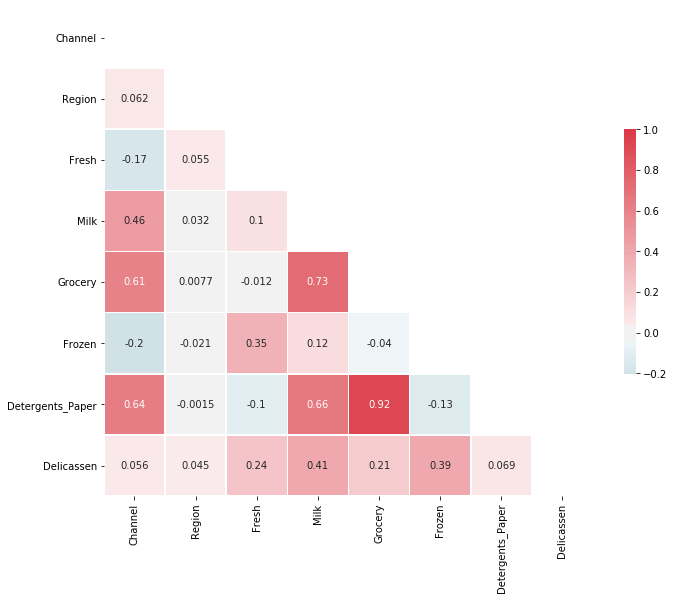

In [10]:
def correlation_matrix(data):
    corr=data.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

correlation_matrix(customers)

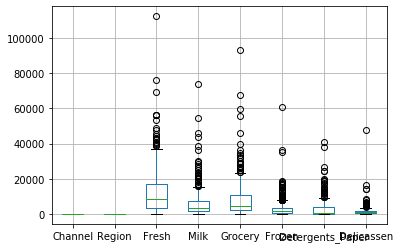

In [11]:
customers.boxplot()

In [12]:
customers.skew()

Channel              0.760951
Region              -1.283627
Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
dtype: float64

In [13]:
# Your observations here

"""
Columns:
    Channel = Channel of order
    Region  = Region of order
    Type of products ordered [Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassem]
    
Theres two categorical data to convert (Channel & Region)

Theres no missing data or nan to deal with.

These columns have a high correlation value:
    Grocery with Detergent
    Channel with Milk, Detergent and Grocery
    Milk with Detergent and Grocery
    
Theres outliers to deal with on Fresh Groceries, Frozen and Delicassen

Ant to conclude theres is a left skewed on the distribution on Delicassen, Frozen, Milk.
"""

'\nColumns:\n    Channel = Channel of order\n    Region  = Region of order\n    Type of products ordered [Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassem]\n    \nTheres two categorical data to convert (Channel & Region)\n\nTheres no missing data or nan to deal with.\n\nThese columns have a high correlation value:\n    Grocery with Detergent\n    Channel with Milk, Detergent and Grocery\n    Milk with Detergent and Grocery\n    \nTheres outliers to deal with on Fresh Groceries, Frozen and Delicassen\n\nAnt to conclude theres is a left skewed on the distribution on Delicassen, Frozen, Milk.\n'

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

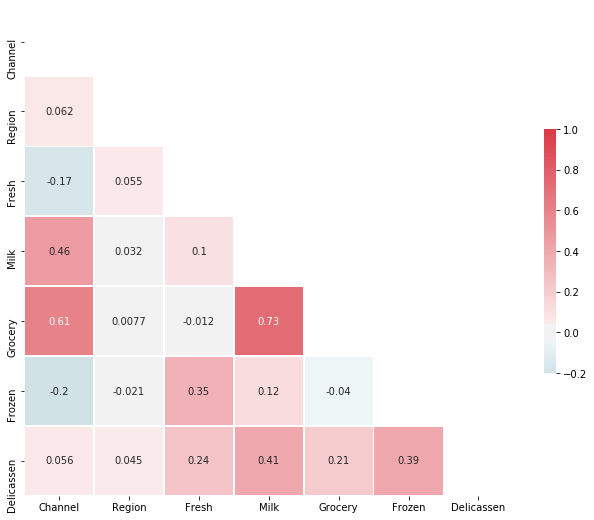

In [14]:
# Your code here

customers.drop('Detergents_Paper',axis=1,inplace=True)

correlation_matrix(customers)

In [15]:
customers.drop(customers[customers['Fresh']==customers['Fresh'].max()].index,inplace=True)
customers.drop(customers[customers['Grocery']==customers['Grocery'].max()].index,inplace=True)
customers.drop(customers[customers['Frozen']==customers['Frozen'].max()].index,inplace=True)
customers.drop(customers[customers['Delicassen']==customers['Delicassen'].max()].index,inplace=True)

In [18]:
# Your comment here

customers.shape

(436, 7)

In [19]:
customers.skew()

Channel       0.757702
Region       -1.277824
Fresh         1.891881
Milk          4.347173
Grocery       2.753184
Frozen        3.254631
Delicassen    4.390551
dtype: float64

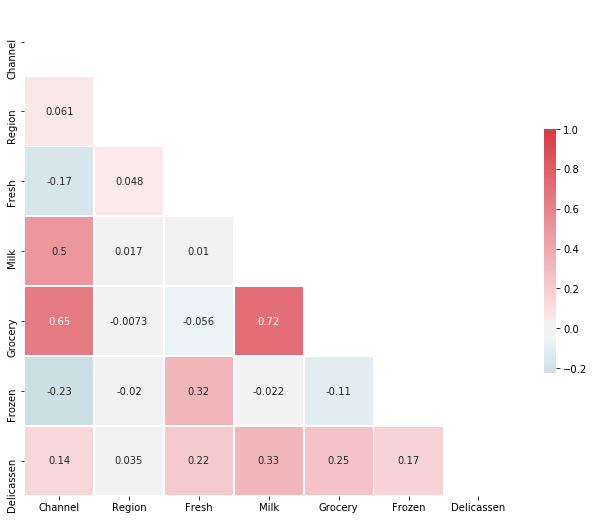

In [20]:
correlation_matrix(customers)

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [21]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

sc=StandardScaler()
#sc.fit(customers[columns=[]])
cat=['Fresh','Milk','Grocery','Frozen','Delicassen']
customers[cat]
sc.fit(customers[cat])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
features_transformed=sc.transform(customers[cat])
features_transformed=pd.DataFrame(features_transformed, columns=['Fresh_t','Milk_t','Grocery_t','Frozen_t','Delicassen_t'])
customers_scale=pd.concat([customers, features_transformed], axis=1)

In [23]:
customers_scale['Channel']=customers_scale['Channel']-1
customers_scale['Region']=customers_scale['Region']-1
customers_scale.dropna(inplace=True)

In [ ]:
#Challenge 4 - Data Clustering with K-Means¶
#Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the .fit method, there is an attribute called labels_ which is the cluster number assigned to each data record. What you can do is to assign these labels back to customers in a new column called customers['labels']. Then you'll see the cluster results of the original data.

In [24]:
# Your code here:

from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=6, random_state=0)

kmeans.fit(customers_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Count the values in `labels`.

In [25]:
# Your code here:

customers_scale['labels']=kmeans.fit(customers_scale).labels_
customers_scale['labels'].value_counts()

3    192
0    104
1     93
4     21
2     19
5      3
Name: labels, dtype: int64

In [26]:
customers_scale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,Fresh_t,Milk_t,Grocery_t,Frozen_t,Delicassen_t,labels
0,1.0,2.0,12669.0,9656.0,7561.0,214.0,1338.0,0.086971,0.606666,-0.015293,-0.727029,-0.030387,1
1,1.0,2.0,7057.0,9810.0,9568.0,1762.0,1776.0,-0.395153,0.629344,0.218482,-0.297791,0.227192,1
2,1.0,2.0,6353.0,8808.0,7684.0,2405.0,7844.0,-0.455634,0.481792,-0.000966,-0.119497,3.795659,1
3,0.0,2.0,13265.0,1196.0,4221.0,6404.0,1788.0,0.138173,-0.639132,-0.404335,0.989366,0.234249,3
4,1.0,2.0,22615.0,5410.0,7198.0,3915.0,5185.0,0.941426,-0.018589,-0.057575,0.299203,2.231955,0


# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [27]:
# Your code here

from sklearn.cluster import DBSCAN

dbscan=DBSCAN(eps=0.5)
cat=['Fresh','Milk','Grocery','Frozen','Delicassen','labels']
customers_scale['labels_DBSCAN']=dbscan.fit(customers_scale.drop(cat,axis=1)).labels_

In [28]:
customers_scale

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,Fresh_t,Milk_t,Grocery_t,Frozen_t,Delicassen_t,labels,labels_DBSCAN
0,1.0,2.0,12669.0,9656.0,7561.0,214.0,1338.0,0.086971,0.606666,-0.015293,-0.727029,-0.030387,1,-1
1,1.0,2.0,7057.0,9810.0,9568.0,1762.0,1776.0,-0.395153,0.629344,0.218482,-0.297791,0.227192,1,-1
2,1.0,2.0,6353.0,8808.0,7684.0,2405.0,7844.0,-0.455634,0.481792,-0.000966,-0.119497,3.795659,1,-1
3,0.0,2.0,13265.0,1196.0,4221.0,6404.0,1788.0,0.138173,-0.639132,-0.404335,0.989366,0.234249,3,-1
4,1.0,2.0,22615.0,5410.0,7198.0,3915.0,5185.0,0.941426,-0.018589,-0.057575,0.299203,2.231955,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.0,2.0,8533.0,5506.0,5160.0,13486.0,1498.0,1.550353,0.959348,0.970826,2.855772,0.478890,3,-1
432,0.0,2.0,21117.0,1162.0,4754.0,269.0,395.0,2.368641,-0.604527,-0.807006,0.464188,0.562397,0,-1
433,0.0,2.0,1982.0,3218.0,1493.0,1541.0,1449.0,0.246934,1.465472,2.626703,-0.665194,0.280707,3,-1
434,0.0,2.0,16731.0,3922.0,7994.0,688.0,838.0,-0.117408,-0.523535,-0.636013,-0.498546,0.432431,0,-1


Count the values in `labels_DBSCAN`.

In [29]:
# Your code here
customers_scale['labels_DBSCAN'].value_counts()

-1    313
 0     86
 4     13
 2      9
 3      6
 1      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

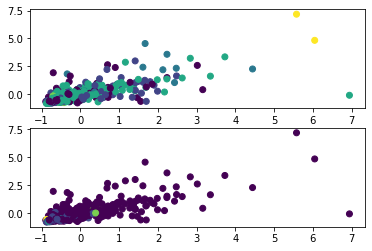

In [30]:
# Your code here:

x=customers_scale['Grocery_t']
y=customers_scale['Milk_t']

f,(ax1,ax2) = plt.subplots(2,1)
ax1.scatter(x,y,c=customers_scale['labels'])
ax2.scatter(x,y,c=customers_scale['labels_DBSCAN'])

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

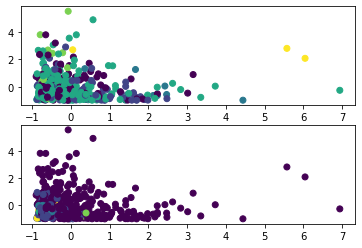

In [31]:
# Your code here:

x=customers_scale['Grocery_t']
y=customers_scale['Fresh_t']

f,(ax1,ax2) = plt.subplots(2,1)
ax1.scatter(x,y,c=customers_scale['labels'])
ax2.scatter(x,y,c=customers_scale['labels_DBSCAN'])

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

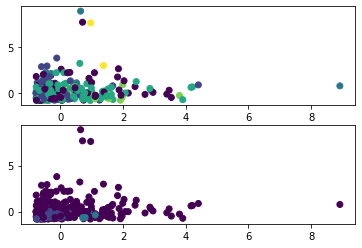

In [32]:
# Your code here:

x=customers_scale['Frozen_t']
y=customers_scale['Delicassen_t']

f,(ax1,ax2) = plt.subplots(2,1)
ax1.scatter(x,y,c=customers_scale['labels'])
ax2.scatter(x,y,c=customers_scale['labels_DBSCAN'])

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [33]:
# Your code here:

columns_t=['Fresh_t','Milk_t','Grocery_t','Frozen_t','Delicassen_t']
customers_scale.groupby('labels')[columns_t].mean()

,Fresh_t,Milk_t,Grocery_t,Frozen_t,Delicassen_t
labels,,,,,
0,0.156463,-0.076524,-0.115817,0.141713,0.179224
1,-0.286941,0.081072,0.182535,-0.278870,-0.056155
2,-0.254149,0.876853,0.698913,0.337089,0.613003
3,-0.051994,-0.137322,-0.102712,-0.054644,-0.148138
4,0.900713,-0.466806,-0.547633,0.633332,-0.272760
5,2.540144,3.978127,3.890780,0.817079,3.658636


In [34]:
customers_scale.groupby('labels_DBSCAN')[columns_t].mean()

,Fresh_t,Milk_t,Grocery_t,Frozen_t,Delicassen_t
labels_DBSCAN,,,,,
-1,0.138243,0.163378,0.207381,0.137009,0.168171
0,-0.290684,-0.518528,-0.571824,-0.378501,-0.434795
1,-0.215293,-0.541412,-0.708813,0.869690,-0.521551
2,-0.615263,-0.613722,-0.698227,-0.463824,-0.526726
3,-0.710942,0.134755,0.301455,-0.659972,0.098598
4,-0.467793,-0.547278,-0.696350,-0.467661,-0.509175


Which algorithm appears to perform better?

In [ ]:
"""
I would say the DBSCAN since we can see better correlation values
"""

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here